# **Receipt Data Extraction**

 This project focuses on the extraction of text from receipts using OCR techniques. The objective is to automate the retrieval of structured data from receipt images, enabling businesses to digitize financial records efficiently.
The project employs PaddleOCR, an deep-learning-based OCR framework, in combination with OpenCV for image preprocessing.
The project is structured into three main parts: image preprocessing, which enhances focus on product details; OCR processing, which involves merging detection boxes for accurate text extraction; and post-processing, which is specifically tailored to extract text from Unimarkt company receipts.

**Table of content**

1. **[Imoprt Libary](#1-import-libary)**
2. **[Pre Processing Functions](#2-pre-processing-functions)**
    -  **[Pre Processing pipeline](#preprocessing-pipeline)**
3. **[OCR Process Functions](#3-ocr-process)**
    - **[Ocr Process Pipeline](#ocr-process-pipeline)**
4. **[Post Processing Functions](#4-post-processing-function)**
5. **[Final Pipeline](#5-final-pipeline)**
6. **[Conclusion](#6--conclusion)**
7. **[Limitation](#7--limitation)**
8. **[Reference](#8--reference)**

<a id="1-import-libary"></a>
# 1. Import libary

In [1]:
import gradio as gr
from paddleocr import PaddleOCR, draw_ocr
from PIL import Image, ImageEnhance, ImageDraw, ImageFont
import numpy as np
from docx import Document
import cv2
import matplotlib.pyplot as plt
import re
import pandas as pd

c:\Users\manoj\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# test image path

img1 ='unimart/3_jpg.rf.f0e2fa578d875c968d9476ce9cad2145.jpg'
img2 ='unimart/7_jpg.rf.402e098f47b3ddad0063fce6c13cd77f.jpg'
img3 ='unimart/6_jpg.rf.8b3ee680e656a91e25ec372b79763d5f.jpg'
img4 ='unimart/8_jpg.rf.bf3efb67c661c77894aaf61b2c3e6623.jpg'
img5 = 'unimart/4_jpg.rf.6a0abbdab969f85658499cc84e33d326.jpg'

<a id="2-pre-processing-functions"></a>
# 2. Pre processing Functions

In [3]:

def biggest_contour(contours):
    """
    Find the biggest contour with four sides.

    Parameters:
    contours (list): List of detected contours.

    Returns:
    np.array: The largest quadrilateral contour found.
    """
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 1000:  # Ignore small contours
            peri = cv2.arcLength(i, True)  # Calculate perimeter
            approx = cv2.approxPolyDP(i, 0.015 * peri, True)  # Approximate contour shape
            if area > max_area and len(approx) == 4:  # Check if it has 4 sides
                biggest = approx
                max_area = area
    return biggest


In [4]:


def correct_orientation(image_path):
    """
    Correct the orientation of the image using contour.

    Parameters:
    image_path (str): Path of input image.

    Returns:
    np.array: Corrected image as a NumPy array.
    """
    # Load the image (OpenCV reads in BGR format)
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Error loading image file.")

    img_original = img.copy()

    # Convert image to grayscale and reduce noise
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 20, 30, 30)

    # Detect edges using Canny edge detection
    edged = cv2.Canny(gray, 10, 20)

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area and keep the top 10 largest ones
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    # Find the biggest contour that forms a quadrilateral
    biggest = biggest_contour(contours)

    # If no valid contour found, return original image
    if biggest.size == 0:
        print("No valid contour detected. Returning original image.")
        return img_original

    # Reshape contour points for transformation
    points = biggest.reshape(4, 2)

    # Order points correctly
    input_points = np.zeros((4, 2), dtype="float32")
    # Order the points: top-left, top-right, bottom-left, bottom-right
    points_sum = points.sum(axis=1)  # Sum of (x, y) coordinates
    input_points[0] = points[np.argmin(points_sum)]  # Top-left
    input_points[3] = points[np.argmax(points_sum)]  # Bottom-right

    points_diff = np.diff(points, axis=1)  # Difference (x - y)
    input_points[1] = points[np.argmin(points_diff)]  # Top-right
    input_points[2] = points[np.argmax(points_diff)]  # Bottom-left

    # Extract ordered points
    (top_left, top_right, bottom_right, bottom_left) = input_points

    # Compute dimensions for transformation
    bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
    top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
    right_height = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
    left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))

    max_width = max(int(bottom_width), int(top_width))
    max_height = max(int(left_height), int(right_height))
    

    # Define destination points
    converted_points = np.float32([
        [0, 0], [max_width, 0], [0, max_height], [max_width, max_height]
    ])

    # Compute transformation matrix
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)

    # Apply perspective warp
    img_output = cv2.warpPerspective(img_original, matrix, (max_width, max_height))

   

    return img_output  # Returns a NumPy array 



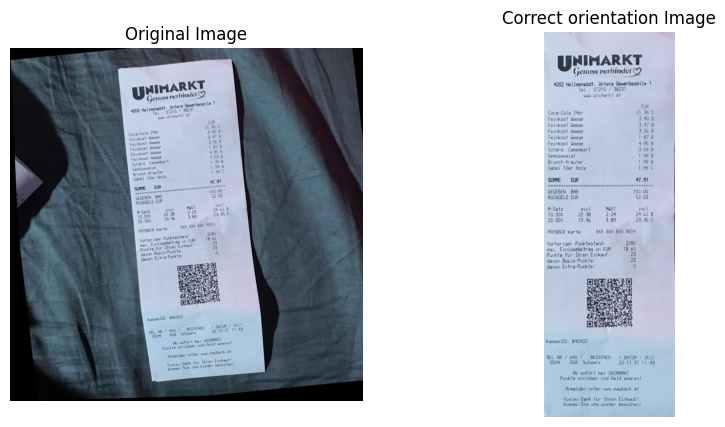

In [5]:
corr_ori_img = correct_orientation(img3)
# draw image output
fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 

# original image
axes[0].imshow(cv2.imread(img3)) 
axes[0].set_title('Original Image')
axes[0].axis('off')  
# Corrected image
axes[1].imshow(corr_ori_img) 
axes[1].set_title('Correct orientation Image')
axes[1].axis('off') 

plt.show()

In [6]:
def crop_image(image):

    height, width = image.shape[:2]
    start_y = int(height * 0.12)  # Start from 10% from the top
    end_y = int(height * 0.55)    # End at 55% from the top
    # Crop the image
    cropped_image = image[start_y:end_y, 0:width]

    # # Resize image with increased height
    # height, width = cropped_image.shape[:2]
    
    # scale_factor = 0.75
    # cropped_image = cv2.resize(cropped_image, (width, int(height * scale_factor)), interpolation=cv2.INTER_LINEAR)
    
    return cropped_image


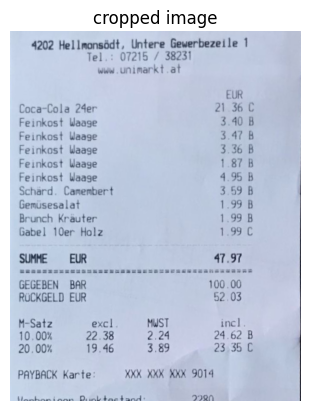

In [7]:

cropped_image = crop_image(correct_orientation(img3))
plt.imshow(cropped_image)
plt.title('cropped image')
plt.axis('off')  
plt.show()


In [8]:
def enhance_contrast_clahe(image):
    """
    Enhance the contrast of the image using CLAHE.

    Parameters:
    image (numpy.ndarray): Input image.

    Returns:
    numpy.ndarray: Contrast-enhanced image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    
    return enhanced

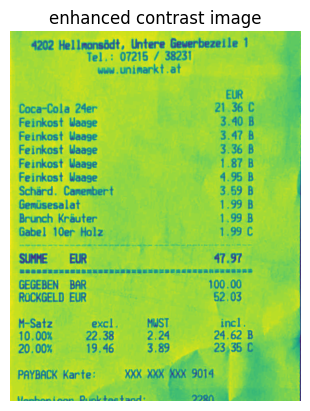

In [9]:
plt.imshow(enhance_contrast_clahe(cropped_image))
plt.title('enhanced contrast image')
plt.axis('off')  
plt.show()

<a id="preprocessing-pipeline"></a>
## Preprocessing Pipeline


In [10]:
# preprocessing pipeline
def preprocess_image(image_path):
    """
    Preprocess the image: correct orientation, cropping and enhance contrast.

    Parameters:
    image_path (str): Path to input image.

    Returns:
    str: Path to preprocessed image.
    """
   
    image = correct_orientation(image_path)

    cropped_image = crop_image(image)

    enhanced_image = enhance_contrast_clahe(cropped_image)

    # Save the preprocessed image 
    preprocessed_image_path = "outputs/preprocessed_image.png"
    cv2.imwrite(preprocessed_image_path, enhanced_image)

    return preprocessed_image_path  



In [11]:
# testing preprocess pipeline
print(preprocess_image(img3))

outputs/preprocessed_image.png


<a id="3-ocr-process"></a>
# 3. OCR Process

[2025/02/07 23:35:59] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\manoj/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\manoj/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batc

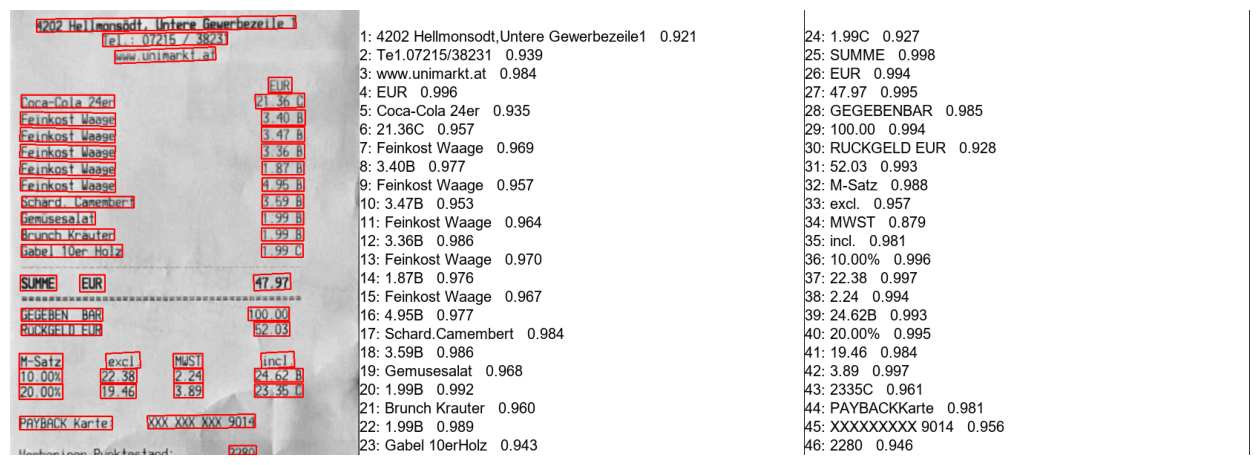

In [12]:
# Initialize PaddleOCR
ocr = PaddleOCR(
    use_angle_cls=True,
    lang='german',
    # det_db_box_thresh=0.6,  
    # det_db_unclip_ratio=1.0, 
    # det_db_box_type="quad"
    )
# Initiate the ocr engin
results = ocr.ocr(preprocess_image(img3))

# draw result
result = results[0]
image = Image.open(preprocess_image(img3)).convert('RGB')
boxes = [line[0] for line in result]
txts = [line[1][0] for line in result]
scores = [line[1][1] for line in result]

font_path = 'C:/Windows/Fonts/arial.ttf'  # Path to a default font
im_show = draw_ocr(image, boxes,txts, scores, font_path=font_path)
im_show = Image.fromarray(im_show)

plt.figure(figsize=(16,8)) # img resized 
plt.imshow(im_show)
plt.axis('off')
plt.show()

**Merging all detected box in a single line then apply recognition**

In [13]:

# Function to merge boxes in the same line
def merge_boxes(result, y_threshold=10):
    lines = []
    current_line = []
    
    # Sort boxes by y-coordinate
    sorted_boxes = sorted(result[0], key=lambda x: x[0][0][1])
    
    for box in sorted_boxes:
        if not current_line:
            current_line.append(box)
        else:
            # Compare y-coordinates to determine if they are in the same line
            last_box = current_line[-1]
            if abs(box[0][0][1] - last_box[0][0][1]) < y_threshold:
                current_line.append(box)
            else:
                lines.append(current_line)
                current_line = [box]
    if current_line:
        lines.append(current_line)
    
    # Merge boxes in each line
    merged_boxes = []
    for line in lines:
        x_coords = [point[0] for box in line for point in box[0]]
        y_coords = [point[1] for box in line for point in box[0]]
        merged_box = [
            [min(x_coords), min(y_coords)],
            [max(x_coords), min(y_coords)],
            [max(x_coords), max(y_coords)],
            [min(x_coords), max(y_coords)]
        ]
        merged_boxes.append(merged_box)
    
    return merged_boxes




[2025/02/07 23:36:04] ppocr DEBUG: dt_boxes num : 46, elapsed : 0.12637567520141602
[2025/02/07 23:36:04] ppocr DEBUG: cls num  : 46, elapsed : 0.07343649864196777
[2025/02/07 23:36:06] ppocr DEBUG: rec_res num  : 46, elapsed : 2.5069661140441895


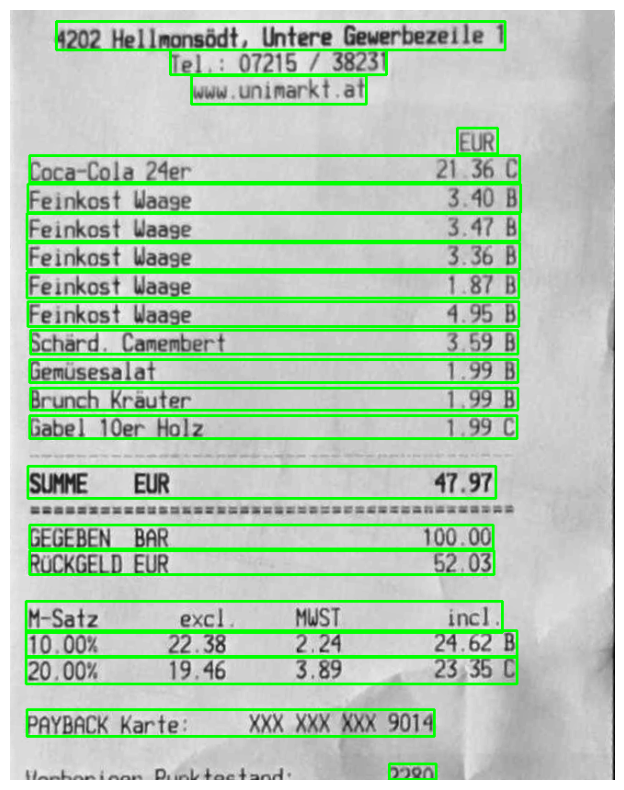

In [14]:
# Load the image
image_path = preprocess_image(img3)
image = cv2.imread(image_path)

# Perform OCR to get detection boxes and text
result = ocr.ocr(image)

# Merge boxes
merged_boxes = merge_boxes(result)

# visualize the merged boxes
for box in merged_boxes:
    box = np.array(box, dtype=np.int32)
    cv2.polylines(image, [box], isClosed=True, color=(0, 255, 0), thickness=2)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()


In [15]:

# Perform text recognition on merged boxes
def extract_text_merged_boxes(merged_boxes, image):

    lines = []
    for box in merged_boxes:
        # Crop the region from the image
        x_min, y_min = int(box[0][0]), int(box[0][1])
        x_max, y_max = int(box[2][0]), int(box[2][1])
        cropped_image = image[y_min:y_max, x_min:x_max]
        
        # Perform OCR on the cropped image
        ocr_result = ocr.ocr(cropped_image, det=False, rec=True)
        for line in ocr_result:
            lines.append(line)

    cleaned_lines =  [line for line in lines if line is not None]
    extracted_text = [line[0][0] for line in cleaned_lines]
    return extracted_text


<a id="ocr-process-pipeline"></a>
## ocr process pipeline

In [16]:

def ocr_process_img(image_path):
    
    image = cv2.imread(image_path)

    # Perform OCR to get detection boxes and text
    result = ocr.ocr(image)
    # merge boxes in each line
    merged_boxes = merge_boxes(result)
    # extract receipt data as text list
    extracted_text = extract_text_merged_boxes(merged_boxes, image)

    return extracted_text
    

In [17]:
# show the extracted text 
extracted_text = ocr_process_img(preprocess_image(img3))
extracted_text

[2025/02/07 23:36:07] ppocr DEBUG: dt_boxes num : 46, elapsed : 0.1337718963623047
[2025/02/07 23:36:07] ppocr DEBUG: cls num  : 46, elapsed : 0.06904149055480957
[2025/02/07 23:36:09] ppocr DEBUG: rec_res num  : 46, elapsed : 2.4700067043304443


['4202 Hellmonsödt,Untere Gewerbezeile1',
 'Tel.07215/38231',
 'www.unimarkt.at',
 'EUR',
 '212222150',
 'FeinkostWaage3.40B',
 'FeinkostWaage3.47B',
 'FeinkostWaage3.36B',
 'FeinkostWaage1.87B',
 'FeinkostWaage4.95B',
 'Schard.Camembert3.59B',
 'Gemusesalat1.99B',
 'BrunchKrauter-1.99B',
 'Gabel10erHolz1.99C',
 'SUMMEEUR47.97',
 'GEGEBENBAR100.00',
 '50298CC39XC',
 'M-Satzexcl.MuSTincl.',
 '10.00%22.382.2424.62B',
 '20.00%19.463.892335',
 'PAYBACKKarteXXXXXXXXX9014',
 '2280']

<a id="4-post-processing-function"></a>
# 4. Post processing function

In [18]:
def extract_products_and_total(text_list):
    separated_data = []
    products = []
    residues = []
    total_price = None
    total_price_line = None
    
    # Define regex pattern for single product entries (product name + price + currency)
    product_pattern = re.compile(r'^(?P<name>[\w\s\.\-]+?)\s*(?P<price>\d*\.?\d+)\s*(B|C|Cn|Bn)$', re.UNICODE)

    # Define regex pattern for quantity-based product entries (quantity X name + unit price + total price + currency)
    quantity_pattern = re.compile(r'^(?P<quantity>\d*)\s*[Xx]\s*(?P<noise>[\w\s\.\-\:]+?)\s*(?P<unit_price>\d*\.?\d+)\s*(?P<price>\d*\.?\d+)\s*(B|C|Cn|Bn)$', re.UNICODE)
    
    # Define regex pattern to match total price (common keywords like "SUMME" or "EUR")
    total_price_pattern = re.compile(r'\b(EUR|SUMME|SUHHE|S[UO]MM?E|E[UO]R|SUH+E)\s*(EUR)?\s*(?P<total>\d+\.\d{2})$')
    
    # Add  products, quantities, or total price in a list
    for line in text_list:
       
        if product_pattern.match(line):
            products.append('_'+line)
            residues = []

        elif quantity_pattern.match(line):
            if residues:
                products.append(residues[-1]+'_'+line)
                residues = []

        elif total_price_pattern.match(line):
            total_price_line = line
            break

        else : 
            residues.append(line)
            if len(residues) == 1 and products:
                products[-1] = line+' '+products[-1]

    # Refined regex for parsing quantity-based products
    quantity_pattern = re.compile(r'^(?P<name>[\w\s\.\-]+?)_(?P<quantity>\d*)\s*[Xx]\s*(?P<noise>[\w\s\.\-\:]+?)\s*(?P<unit_price>\d*\.?\d{2})\s*(?P<price>\d*\.?\d{2})\s*(B|C|Cn|Bn)$', re.UNICODE)

    # Extract product details from products list
    for product in products:
        
        match_product_quantanty = re.match(quantity_pattern, product)
        match_product = re.match(product_pattern, product)

        if match_product_quantanty:
            product_name = match_product_quantanty.group(1).strip()
            quantity = match_product_quantanty.group(2)
            price = float(match_product_quantanty.group(5))
            separated_data.append({'Product_Name': product_name, 'Price': price, 'Quantity': quantity})

        elif match_product:
            product_name = match_product.group(1).strip()
            price = float(match_product.group(2))
            separated_data.append({'Product_Name': product_name, 'Price': price, 'Quantity': 1})

    # Extract total price if found
    if total_price_line :
        match_total = re.match(total_price_pattern, total_price_line)
        if match_total:
            total_price = match_total.group(3)
    # Append total price as a final entry
    separated_data.append({'Product_Name': "Total price", 'Price': total_price})
    
    return separated_data


In [19]:
data = extract_products_and_total(extracted_text)
data

[{'Product_Name': '_FeinkostWaage', 'Price': 3.4, 'Quantity': 1},
 {'Product_Name': '_FeinkostWaage', 'Price': 3.47, 'Quantity': 1},
 {'Product_Name': '_FeinkostWaage', 'Price': 3.36, 'Quantity': 1},
 {'Product_Name': '_FeinkostWaage', 'Price': 1.87, 'Quantity': 1},
 {'Product_Name': '_FeinkostWaage', 'Price': 4.95, 'Quantity': 1},
 {'Product_Name': '_Schard.Camembert', 'Price': 3.59, 'Quantity': 1},
 {'Product_Name': '_Gemusesalat', 'Price': 1.99, 'Quantity': 1},
 {'Product_Name': '_BrunchKrauter-', 'Price': 1.99, 'Quantity': 1},
 {'Product_Name': '_Gabel10erHolz', 'Price': 1.99, 'Quantity': 1},
 {'Product_Name': 'Total price', 'Price': '47.97'}]

In [20]:
df = pd.DataFrame(data)
# clean Product name
df['Product_Name'] = df['Product_Name'].apply(lambda x: x.replace('_',' '))

In [21]:
# show data in pandas dataframe
df

,Product_Name,Price,Quantity
0,FeinkostWaage,3.4,1.0
1,FeinkostWaage,3.47,1.0
2,FeinkostWaage,3.36,1.0
3,FeinkostWaage,1.87,1.0
4,FeinkostWaage,4.95,1.0
5,Schard.Camembert,3.59,1.0
6,Gemusesalat,1.99,1.0
7,BrunchKrauter-,1.99,1.0
8,Gabel10erHolz,1.99,1.0
9,Total price,47.97,NaN


<a id="5-final-pipeline"></a>
# 5. Final Pipeline

In [22]:
def main_pipeline(image_path):

    preprocess_image_path = preprocess_image(image_path)

    extracted_text = ocr_process_img(preprocess_image_path)

    data = extract_products_and_total(extracted_text)

    
    df = pd.DataFrame(data)
    if df.empty:
        print("DataFrame is empty. Check extracted data.")

    # Clean Product Name
    df['Product_Name'] = df['Product_Name'].str.replace('_', ' ')
    # Save to Excel
    excel_path = "outputs/products.xlsx"
    df.to_excel(excel_path, index=False)

    return df,excel_path

    

In [23]:
# test main_pipeline
df, _ = main_pipeline(img3)

[2025/02/07 23:36:15] ppocr DEBUG: dt_boxes num : 46, elapsed : 0.28360605239868164
[2025/02/07 23:36:15] ppocr DEBUG: cls num  : 46, elapsed : 0.12981367111206055
[2025/02/07 23:36:18] ppocr DEBUG: rec_res num  : 46, elapsed : 2.737309217453003


In [24]:
# showing result
df

,Product_Name,Price,Quantity
0,FeinkostWaage,3.4,1.0
1,FeinkostWaage,3.47,1.0
2,FeinkostWaage,3.36,1.0
3,FeinkostWaage,1.87,1.0
4,FeinkostWaage,4.95,1.0
5,Schard.Camembert,3.59,1.0
6,Gemusesalat,1.99,1.0
7,BrunchKrauter-,1.99,1.0
8,Gabel10erHolz,1.99,1.0
9,Total price,47.97,NaN


<a id = 'conclusion'></a>
# 6.  Conclusion

The OCR pipeline automates text extraction, reducing manual data entry. Preprocessing, OCR process, and post-processing improve accuracy of text extraction. PaddleOCR effectively handles varied fonts and layouts.

Future improvements can include deep learning-based enhancements and template matching.

<a id = 'limitation'></a>
# 7.  Limitation

- **Image Quality Dependence:** Low-resolution or blurry images reduce OCR accuracy.

- **Font & Layout Variations:** Different fonts and layouts in receipts pose challenges in text alignment.

- **Corner Dependency:** The preprocessing process relies on clearly visible receipt corners to accurately crop the receipt from the input image.

- **Language & Character Set:** OCR performance may decline for languages or character sets not supported by PaddleOCR.

- **Preprocessing Challenges:** Over-processing can sometimes distort text instead of improving recognition.

<a id = 'reference'></a>
# 8.  Reference

PaddleOCR Documentation: https://github.com/PaddlePaddle/PaddleOCR

OpenCV Documentation: https://opencv.org/

Pandas Library: https://pandas.pydata.org/

Regular Expressions in Python: https://docs.python.org/3/library/re.html

Gradio for Interface Building: https://www.gradio.app/

Matplotlib for Visualization: https://matplotlib.org/

___